# Preprocessing — přehled

1. Setup — imports & environment
2. Database — načtení `historical_posts` a `historical_comments`
3. Load tickers — načtení a normalizace seznamu tickerů (NASDAQ + NYSE)
4. Data harmonization <br>
   4.1 Sjednocení schémat do `df_unified`<br>
   4.2 Placeholder-only rows analysis — analýza řádků s pouze placeholdery<br>
   4.3 Odstranění [removed]/[deleted] placeholderů<br>
   4.4 Spojení `title` + `body` pro posty do `text`<br>
5. EDA — overview, missingness, text length, temporal analysis <br>
   5.1 Data types & schema overview — kontrola datových typů<br>
   5.2 Column value distributions — unikátní hodnoty, konstantní sloupce<br>
   5.3 Overview — counts & missingness<br>
   5.4 Text characteristics — word count histograms<br>
   5.5 Temporal analysis — day/hour distribution<br>
   5.6 Engagement metrics — upvote ratio<br>
   5.7 Integrity and duplicates — ID uniqueness<br>
6. Data Cleaning — odstranění invalidních/prázdných záznamů, deduplikace, odstranění zbytečných sloupců
7. Feature engineering — text_length, word_count, temporal a engagement features, normalized_score
8. Ticker detection <br>
   8.1 Detekce `mentioned_tickers`, `n_tickers`, `ticker_exchanges`<br>
   8.2 Ticker inheritance — inherit parent post tickers to comments + přepočet exchanges<br>
   8.3 Inheritance success check — analýza úspěšnosti dědění<br>
   8.4 Data Type Conversion — zajištění správných datových typů pro všechny sloupce<br>
9. Text normalization — lowercase, odstranění URLs/interpunkce, stopword removal
10. Export — konverze mentioned_tickers na CSV-friendly string, export `preprocessed_data.csv`
11. Database Export — uložení do Oracle tabulky `preprocessed_data`

**Výstup:** `preprocessed_data.csv` + Oracle tabulka `preprocessed_data`

- **Zde dokumentace k Reddit API, kde najdete popis sloupců: https://praw.readthedocs.io/en/stable/code_overview/models/submission.html?utm_source=chatgpt.com**

- **Silně Doporučuju stahnout tady ve VScodu extension Data Wrangler od Microsoftu. Je to dobry na divani se na dataframy a jsou tam i nejaky data quality metriky a jde ten df otevrit normalne jako dalsi okno tady ve vscodu aktualizovat ho s tim jak se ten dataframe upravuje v prubehu preprocessingu. Obecne mi to prijde jako mega fajn extension.**

- **V levé liště je možná orientace v dokumentu pomocí OUTLINE**

- **Většina použitých funkcí je definována v utils.py a importována sem.**

**ENJOY THE RUN**

## 1 Setup — Imports & environment

Načteme potřebné knihovny a ověříme dostupnost spaCy/NLTK a DB driveru. To nám řekne, které nástroje můžeme použít dál pro čištění a tokenizaci textu.

In [1]:
# 1. Setup: Imports and Configuration

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import os
import re
import time
from datetime import datetime
from typing import List, Set, Dict, Any
from tqdm import tqdm
from io import StringIO
import urllib.request
import urllib.parse

# Environment and database imports
try:
    from dotenv import load_dotenv
    load_dotenv()
    DOTENV_AVAILABLE = True
except ImportError:
    DOTENV_AVAILABLE = False

try:
    import oracledb
    ORACLE_AVAILABLE = True
except ImportError:
    ORACLE_AVAILABLE = False
    print("Oracle DB not available. Install with: pip install oracledb")

# Checking for NLP libraries (if you lack any - install with pip install)
available_libs = []
try:
    import nltk
    NLTK_AVAILABLE = True
    available_libs.append("NLTK")

    # Check if NLTK stopwords are downloaded
    try:
        nltk.data.find('corpora/stopwords')
        print("NLTK stopwords data found")
    except LookupError:
        print("NLTK stopwords not found. Attempting to download...")
        try:
            nltk.download('stopwords', quiet=True)
            print("NLTK stopwords downloaded successfully")
        except Exception as e:
            print(f"Failed to download NLTK stopwords: {e}")
            print("   Will use fallback stopword list")
except ImportError:
    NLTK_AVAILABLE = False

try:
    import spacy
    SPACY_AVAILABLE = True
    available_libs.append("spaCy")

    # Check if spaCy model is available
    try:
        spacy.load("en_core_web_sm")
        print("spaCy 'en_core_web_sm' model found")
    except OSError:
        print("spaCy model 'en_core_web_sm' not found")
        print("   Install with: python -m spacy download en_core_web_sm")
        print("   Will fall back to NLTK if available")
except ImportError:
    SPACY_AVAILABLE = False

# Import functions from utils
from utils import (
    get_oracle_connection,
    get_all_us_tickers,
    detect_tickers_in_text,
    apply_ticker_detection,
    harmonize_schema,
    drop_invalid_texts,
    deduplicate_and_normalize_types,
    add_temporal_features,
    add_engagement_features,
    apply_text_normalization,
    remove_financial_stopwords,
    remove_stopwords_spacy
)

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger(__name__)

# Configuration constants for minimal text lenght of texts to be considered valid and retry delay for operations
MIN_TEXT_LENGTH = 10
RETRY_DELAY = 10

print(f"Step 1: imports loaded — available: {', '.join(available_libs) if available_libs else 'none'}")

NLTK stopwords data found
spaCy 'en_core_web_sm' model found
spaCy 'en_core_web_sm' model found
Step 1: imports loaded — available: NLTK, spaCy
Step 1: imports loaded — available: NLTK, spaCy


## 2 Database — Extract posts & comments

Připojíme se k databázi a stáhneme posty a komentáře z tabulek `historical_posts` a `historical_comments`. 

In [2]:
# 2. Database Connection: Loading Reddit Data from Oracle

print("Step 2: importing Reddit data from Oracle database")

# Check if Oracle DB is available and credentials are set in environment variables
oracle_credentials_available = (
    ORACLE_AVAILABLE and
    os.getenv('db-username') and
    os.getenv('db-password') and
    os.getenv('db-dsn')
)

if oracle_credentials_available:
    print("Oracle credentials found")

    conn = get_oracle_connection()

    if conn:
        print("Database connection successful")

        # Importing data from database
        try:
            # Query to import posts (number of them is set to 1000 for testing, but can be set in the variable)
            query_posts = """
                SELECT
                    author, title, created_utc, id, is_original_content,
                    score, TO_CHAR(body) as body,
                    subreddit, upvote_ratio, url
                FROM historical_posts
                WHERE ROWNUM <= 1000
            """
            df_posts = pd.read_sql_query(query_posts, conn)

            # Query to import comments (number of them is set to 1000 for testing, but can be set in the variable)
            query_comments = """
                SELECT
                    author, created_utc, id, parent_post_id, score,
                    TO_CHAR(body) as body,
                    subreddit
                FROM historical_comments
                WHERE ROWNUM <= 1000
            """
            df_comments = pd.read_sql_query(query_comments, conn)

            # Closing connection immediately after data import so that it does not stay open longer than needed
            conn.close()

            print(f"\nPosts imported: {df_posts.shape}")
            print(f"Comments imported: {df_comments.shape}")

            if len(df_posts) > 0:
                print(f"Posts columns: {list(df_posts.columns)}")

            if len(df_comments) > 0:
                print(f"Comments columns: {list(df_comments.columns)}")

        except Exception as e:
            print(f"Error importing data from database: {e}")
            if conn:
                try:
                    conn.close()
                except:
                    pass
            df_posts = pd.DataFrame()
            df_comments = pd.DataFrame()

    else:
        print("Failed to connect to database - check logs.")
        df_posts = pd.DataFrame()
        df_comments = pd.DataFrame()

else:
    print("Oracle database credentials not configured — set them in .env file or environment variables")
    df_posts = pd.DataFrame()
    df_comments = pd.DataFrame()

print(f"\nStep 2 complete: Loaded {len(df_posts)} posts and {len(df_comments)} comments.")

Step 2: importing Reddit data from Oracle database
Oracle credentials found
Oracle connection successful!
Database connection successful
Oracle connection successful!
Database connection successful


/var/folders/33/r5z8ht2928103xc7s_sb_xx80000gq/T/ipykernel_17505/64887939.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_posts = pd.read_sql_query(query_posts, conn)
/var/folders/33/r5z8ht2928103xc7s_sb_xx80000gq/T/ipykernel_17505/64887939.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_comments = pd.read_sql_query(query_comments, conn)
/var/folders/33/r5z8ht2928103xc7s_sb_xx80000gq/T/ipykernel_17505/64887939.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_comments = pd.read_sql_query(query_comments


Posts imported: (1000, 10)
Comments imported: (1000, 7)
Posts columns: ['AUTHOR', 'TITLE', 'CREATED_UTC', 'ID', 'IS_ORIGINAL_CONTENT', 'SCORE', 'BODY', 'SUBREDDIT', 'UPVOTE_RATIO', 'URL']
Comments columns: ['AUTHOR', 'CREATED_UTC', 'ID', 'PARENT_POST_ID', 'SCORE', 'BODY', 'SUBREDDIT']

Step 2 complete: Loaded 1000 posts and 1000 comments.


## 3 Load tickers — Ticker list & exchanges

Načteme a normalizujeme seznam tickerů (lokálně nebo ze zdroje) - podívej se na strukturu toho csvcka. Podíváme se na rozložení tickerů dle burzy (vychází pořád z toho csvcka).

In [3]:
# 3. Ticker Data Loading: Fetch NASDAQ/NYSE Symbols
us_tickers_path = "us_tickers.csv"

if os.path.exists(us_tickers_path):
    try:
        tickers_df = pd.read_csv(us_tickers_path, dtype=str)
        tickers_df.columns = [c.strip().lower().replace(" ", "_") for c in tickers_df.columns]
        if 'ticker' in tickers_df.columns:
            tickers_df['ticker'] = tickers_df['ticker'].astype(str).str.upper().str.strip()
        print(f"Loaded {len(tickers_df)} cached tickers")
    except Exception as e:
        print(f"Error loading cached data: {e}")
        tickers_df = None
else:
    tickers_df = None

# If no cached data or fresh data
if tickers_df is None or len(tickers_df) == 0:
    try:
        tickers_df = get_all_us_tickers()
        if len(tickers_df) > 0:
            tickers_df.to_csv(us_tickers_path, index=False)
            print(f"Fetched and cached {len(tickers_df)} US tickers")
        else:
            print("No ticker data retrieved.")
    except Exception as e:
        print(f"Error fetching ticker data: {e}")
        tickers_df = pd.DataFrame()

if len(tickers_df) > 0:
    print(f"  Exchanges: {tickers_df['exchange'].value_counts().to_dict()}")

else:
    print("No ticker data available")

print(f"\nStep 3 complete: Loaded {len(tickers_df)} ticker symbols. Letzgoo")

Loaded 8003 cached tickers
  Exchanges: {'NASDAQ': 5118, 'NYSE': 2885}

Step 3 complete: Loaded 8003 ticker symbols. Letzgoo


## 4 Data harmonization — unify posts & comments

Sjednotíme posts a comments do jednoho `df_unified` s konzistentními sloupci (id, text, type, title, parent_post_id...). 

### 4.1 Unifying posts & comments

Sloučíme **df_posts** a **df_comments**, přemapujeme názvy a vytvoříme jednotný sloupec `text`, ktery bude ten nejdulezitejsi sloupec na pozdejsi analyzu. Tady je očekávané to, že u sloupců, které posty mají jen posty, vzniknou v tom samém sloupci pro komentáře NAs. A naopak. To je v pořádku a řešíme to dále.

In [4]:
# 4. Data Harmonization: Merge Posts and Comments

if len(df_posts) > 0 or len(df_comments) > 0:
    # combining data
    df_unified = harmonize_schema(df_posts, df_comments)
    print(f"Unified dataframe shape: {df_unified.shape}")
    print(f"Unified columns: {list(df_unified.columns)}")

    # data type distribution
    type_counts = df_unified['type'].value_counts()
    print(f"\nData distribution:")
    for dtype, count in type_counts.items():
        print(f"  {dtype}: {count} rows")

else:
    print("No data to harmonize")
    df_unified = pd.DataFrame()

print(f"\nStep 4.1 complete: Unified {len(df_unified)} rows. Letzgoo")

/Users/simon2/Library/CloudStorage/OneDrive-Personal/UČENÍ/Textová analytika 2/stock-sentiment-analysis/utils.py:298: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  unified = pd.concat([posts, comments], ignore_index=True, sort=False)
INFO:utils:Harmonized schema. Unified dataframe shape: (2000, 12)


Unified dataframe shape: (2000, 12)
Unified columns: ['author', 'title', 'created_utc', 'id', 'is_original_content', 'score', 'text', 'subreddit', 'upvote_ratio', 'url', 'parent_post_id', 'type']

Data distribution:
  post: 1000 rows
  comment: 1000 rows

Step 4.1 complete: Unified 2000 rows. Letzgoo


### 4.2 Placeholder-only rows analysis

Některé řádky mají **pouze** placeholdery ([removed]/[deleted]) - tohle bylo zjisteno na zaklade inspekce dataframu, ale stejně by to bylo zjištěno později. Tyhle sloupce nemají žádný skutečný obsah → budou smazány v dalším kroku. Tady se podíváme kolik takových řádků máme, a jak jsou rozloženy podle typu (posty vs komenty).

In [5]:
if len(df_unified) == 0:
    print("No data")
else:
    def is_placeholder(s):
        if pd.isna(s):
            return True
        s = str(s).strip().lower()
        return s == '' or s in {'[deleted]', '[removed]', 'nan'}

    text_placeholder = df_unified['text'].apply(is_placeholder)
    title_placeholder = df_unified.get('title', pd.Series(False, index=df_unified.index)).apply(is_placeholder)

    to_drop_mask = (
        ((df_unified['type'] == 'post') & title_placeholder & text_placeholder) |
        ((df_unified['type'] == 'comment') & text_placeholder)
    )

    if to_drop_mask.any():
        print("\nPlaceholder-Only Rows by Type:")

        for t, grp in df_unified[to_drop_mask].groupby('type'):
            print(f"  {t.upper()}: {len(grp):,} rows will be deleted")

            if t == 'post':
                for col in ['title', 'text']:
                    removed = (grp[col].str.strip().str.lower() == '[removed]').sum()
                    deleted = (grp[col].str.strip().str.lower() == '[deleted]').sum()
                    print(f"    {col}: [removed]={removed:,}, [deleted]={deleted:,}")
            else:
                txt = grp['text'].astype(str).str.strip().str.lower()
                removed = (txt == '[removed]').sum()
                deleted = (txt == '[deleted]').sum()
                empty = (txt == '').sum()
                print(f"    text: [removed]={removed:,}, [deleted]={deleted:,}, empty/NA={empty:,}")
    else:
        print("No placeholder-only rows found.")


Placeholder-Only Rows by Type:
  COMMENT: 33 rows will be deleted
    text: [removed]=32, [deleted]=1, empty/NA=0


**Vypadá to, že vždy jsou plný placeholderů jen komenty (většinou [removed])** S lehkým srdcem toto 1% dat mažem v příštím kroku 

### 4.3 deleting [removed]/[deleted] placeholders (**NOT REMOVING MISSING VALUES - THESE ARE HANDLED LATER**)

Místo samotných NAs, je v nadpisech Tohle je udelany, abychom pri pozdejsim feature engineeringu nedostali neco jako: "Emotional investing research. [removed]"

In [6]:
# turning placeholders into empty string
if 'title' in df_unified.columns:
    df_unified['title'] = df_unified['title'].apply(lambda x: '' if is_placeholder(x) else str(x).strip())
if 'text' in df_unified.columns:
    df_unified['text'] = df_unified['text'].apply(lambda x: '' if is_placeholder(x) else str(x).strip())

# Dropping posts where both title and text are empty after cleaning
before = len(df_unified)
mask_empty_post = (df_unified['type'] == 'post') & (df_unified.get('title', '').astype(str).str.strip() == '') & (df_unified.get('text', '').astype(str).str.strip() == '')
mask_empty_comment = (df_unified['type'] == 'comment') & (df_unified.get('text', '').astype(str).str.strip() == '')

# For comments we will drop those with empty body. For posts we will drop only if both title+text empty
to_drop = mask_empty_post | mask_empty_comment
df_unified = df_unified[~to_drop].reset_index(drop=True)
after = len(df_unified)
print(f"We removed {before - after} placeholder-only rows (kept posts with title if present).")

We removed 33 placeholder-only rows (kept posts with title if present).


### 4.4 Merging title + body for posts into **text** column

U postů spojíme `title` s tělem, protože titul často obsahuje klíčovou informaci nebo ticker. Title a to tělo spolu přímo souvisí a je to vlastně jedna entita (tedy post). Reálně není důvod proč to neudělat a navíc můžeme poté smazat sloupec title, který byl stejně z půlky NAs (komentare nemaji title), což prakticky nevadilo. Zvýší to později šanci, že detekce tickerů a sentimentu zachytí o čem post reálně je.

In [7]:
# 4.4 Enhanced Text: Merge Title + Body for Posts

if len(df_unified) > 0:

    # For posts: concatenate title + body
    # For comments: keep body only (no title)
    def create_enhanced_text(row):
        if row['type'] == 'post':
            title = str(row.get('title', '')).strip()
            body = str(row.get('text', '')).strip()
            # Combine title and body with separator
            if title and title != 'nan' and body and body != 'nan':
                return f"{title}. {body}"
            elif title and title != 'nan':
                return title
            elif body and body != 'nan':
                return body
            else:
                return ''
        else:
            # Comments: use text only
            return str(row.get('text', '')).strip()

    df_unified['enhanced_text'] = df_unified.apply(create_enhanced_text, axis=1)

    # Replace 'text' column with enhanced version
    df_unified['text'] = df_unified['enhanced_text']
    df_unified.drop(columns=['enhanced_text'], inplace=True)

    # We can safely drop title column since it's now merged into text (and later ticker detection is done on the "text" column)
    if 'title' in df_unified.columns:
        df_unified.drop(columns=['title'], inplace=True)
        print("Dropped 'title' column (merged into 'text')")

    print(f"Done")

else:
    print("No data to enhance")

Dropped 'title' column (merged into 'text')
Done


## 5 Exploratory Data Analysis (EDA)

Projdeme kvalitu dat a základní statistiky, abychom věděli jak data dál (pokud je to potřeba) upravit.

### 5.1 Data types chekc/conversion & schema overview

Zkontrolujeme datové typy všech sloupců a případně je upravíme. To nám pomůže identifikovat potenciální problémy v datech a zajistit správné zpracování v dalších krocích.

In [8]:
# 5.1 Data types check

if len(df_unified) > 0:
    print(f"Dataset shape: {df_unified.shape}")

    for col in df_unified.columns:
        dtype = df_unified[col].dtype
        print(f"  {col:20} : {str(dtype):15}")

else:
    print("No data available")

Dataset shape: (1967, 11)
  author               : object         
  created_utc          : int64          
  id                   : object         
  is_original_content  : object         
  score                : int64          
  text                 : object         
  subreddit            : object         
  upvote_ratio         : float64        
  url                  : object         
  parent_post_id       : object         
  type                 : object         


- **Převedeme na správné datové typy**

In [9]:
# DateTime conversion
if 'created_utc' in df_unified.columns:
    df_unified['created_utc'] = pd.to_datetime(df_unified['created_utc'], unit='s', errors='coerce')

# Numeric conversions
numeric_cols = {'score': 'float64', 'upvote_ratio': 'float64'}
for col, dtype in numeric_cols.items():
    df_unified[col] = pd.to_numeric(df_unified[col], errors='coerce').astype(dtype)


# Categorical conversions
for col in ['type', 'subreddit']:
    df_unified[col] = df_unified[col].astype('category')

# String conversions
for col in ['id', 'text', 'author', 'url']:
    df_unified[col] = df_unified[col].astype(pd.StringDtype())

# Handle parent_post_id (preserve NaN)
if 'parent_post_id' in df_unified.columns:
    df_unified['parent_post_id'] = df_unified['parent_post_id'].astype(pd.StringDtype())

# Drop constant column
if 'is_original_content' in df_unified.columns:
    df_unified.drop(columns=['is_original_content'], inplace=True)

print(f"Data types after conversion:")
for col in df_unified.columns:
    dtype = df_unified[col].dtype
    non_null = df_unified[col].notna().sum()
    print(f"{col} : {str(dtype)}")

Data types after conversion:
author : string
created_utc : datetime64[ns]
id : string
score : float64
text : string
subreddit : category
upvote_ratio : float64
url : string
parent_post_id : string
type : category


### 5.2 Column value distributions

Prozkoumáme rozložení hodnot ve sloupcích - počty unikátních hodnot, konstantní sloupce a základní distribuce kategorických proměnných.

In [10]:
# 5.2 Column Value Distributions

if len(df_unified) > 0:
    print("\nUnique Value Counts:")

    for col in df_unified.columns:
        n_unique = df_unified[col].nunique()
        n_total = len(df_unified)
        pct_unique = (n_unique / n_total) * 100

        print(f"  {col:20} : {n_unique:,} unique values ({pct_unique:.1f}% of total)")

    print(f"\nStep 5.2 completed")

else:
    print("No data available")


Unique Value Counts:
  author               : 1,556 unique values (79.1% of total)
  created_utc          : 1,957 unique values (99.5% of total)
  id                   : 1,967 unique values (100.0% of total)
  score                : 100 unique values (5.1% of total)
  text                 : 1,921 unique values (97.7% of total)
  subreddit            : 3 unique values (0.2% of total)
  upvote_ratio         : 85 unique values (4.3% of total)
  url                  : 991 unique values (50.4% of total)
  parent_post_id       : 216 unique values (11.0% of total)
  type                 : 2 unique values (0.1% of total)

Step 5.2 completed


**[is_original_content] má jen hodnotu 0, takže ho později dropneme. Nic jinýho podle mě neznačí nějaký problémy kvůli kterým by stálo za to tohle nějak dále analyzovat či data upravovat.**

### 5.3 Overview — counts & missingness 

Spočítáme počty, podíly chybějících hodnot a zjistíme, kolik záznamů je smazaných nebo prázdných (NAs).

In [11]:
# 5.3 Data Quality & Completeness
if len(df_unified) > 0:

    print("\nNAs by Column:")
    for col in df_unified.columns:
        missing_count = df_unified[col].isna().sum()
        if missing_count > 0:
            missing_pct = (missing_count / len(df_unified)) * 100
            print(f"  {col}: {missing_count:,} ({missing_pct:.1f}%)")

else:
    print("No data available for quality analysis.")


NAs by Column:
  upvote_ratio: 967 (49.2%)
  url: 974 (49.5%)
  parent_post_id: 1,000 (50.8%)


Všechno je v pořádku — chybějící hodnoty v [is_original_content], [upvote_ratio], [url], [parent_post_id] jsou strukturální (posty vs. komentáře mají původně různé sloupce). V data cleaning dropneme is_original_content, url. **Naopak [parent_post_id] určitě nedropujeme.** <br>

Very short texts (≤5 chars): 104 — ty budou odstraněny v kroku 6 (drop_invalid_texts). <br>

### 5.4 Text characteristics

Podíváme se na délky textů, počty slov a percentily, abychom kdyžtak vyfiltrovali moc krátké/dlouhé (druhá možnost spíše ne, není proč). 


Word Count Statistics (Overall):
  Mean: 59.3 words
  Median: 22.0 words
  Min: 1 words
  Max: 2278 words


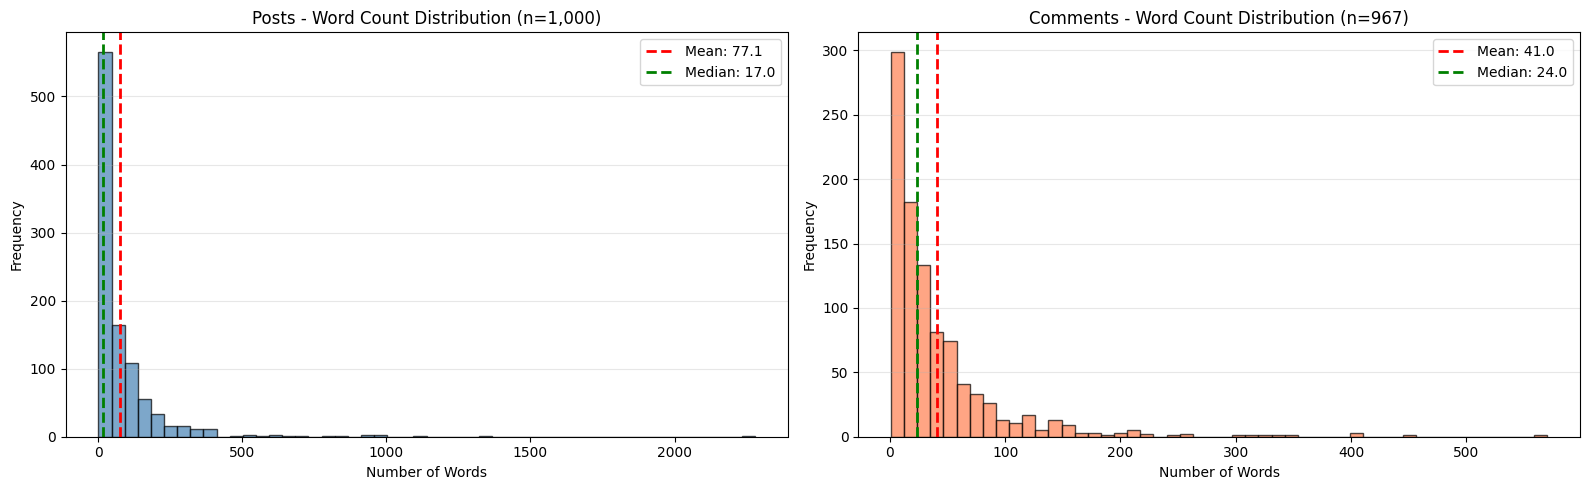


Quality Issues:
  Texts ≤10 chars: 43 (2.2%)


In [12]:
# 5.4 Text Characteristics

if len(df_unified) > 0 and 'text' in df_unified.columns:

    # Calculating text statistics
    valid_texts = df_unified[df_unified['text'].notna() & (df_unified['text'] != '')]

    if len(valid_texts) > 0:
        text_lengths = valid_texts['text'].astype(str).str.len()

        word_counts = valid_texts['text'].astype(str).str.split().str.len()

        print(f"\nWord Count Statistics (Overall):")
        print(f"  Mean: {word_counts.mean():.1f} words")
        print(f"  Median: {word_counts.median():.1f} words")
        print(f"  Min: {word_counts.min()} words")
        print(f"  Max: {word_counts.max()} words")

        if 'type' in valid_texts.columns:
            posts = valid_texts[valid_texts['type'] == 'post']
            comments = valid_texts[valid_texts['type'] == 'comment']

            if len(posts) > 0 and len(comments) > 0:
                post_word_counts = posts['text'].astype(str).str.split().str.len()
                comment_word_counts = comments['text'].astype(str).str.split().str.len()

                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

                # Posts
                ax1.hist(post_word_counts, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
                ax1.axvline(post_word_counts.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {post_word_counts.mean():.1f}')
                ax1.axvline(post_word_counts.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {post_word_counts.median():.1f}')
                ax1.set_xlabel('Number of Words')
                ax1.set_ylabel('Frequency')
                ax1.set_title(f'Posts - Word Count Distribution (n={len(posts):,})')
                ax1.legend()
                ax1.grid(axis='y', alpha=0.3)

                # Comments
                ax2.hist(comment_word_counts, bins=50, edgecolor='black', alpha=0.7, color='coral')
                ax2.axvline(comment_word_counts.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {comment_word_counts.mean():.1f}')
                ax2.axvline(comment_word_counts.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {comment_word_counts.median():.1f}')
                ax2.set_xlabel('Number of Words')
                ax2.set_ylabel('Frequency')
                ax2.set_title(f'Comments - Word Count Distribution (n={len(comments):,})')
                ax2.legend()
                ax2.grid(axis='y', alpha=0.3)

                plt.tight_layout()
                plt.show()
            else:
                print("  Not enough data for separate histograms")

        # Short texts identification
        very_short = (text_lengths <= MIN_TEXT_LENGTH).sum()
        print(f"\nQuality Issues:")
        print(f"  Texts ≤{MIN_TEXT_LENGTH} chars: {very_short:,} ({very_short/len(valid_texts)*100:.1f}%)")

else:
    print("No text data")

**Reálně tu není moc řešit. Tak asi nějak co bychom očekávali. Ten rozdíl není nijak margantní, ale i kdyby byl tak pro účely našeho tasku něco jako outlier v počtu slov neexistuje.**

### 5.5 Temporal analysis

Zkontrolujeme časové rozložení příspěvků (denní/hodinové špičky a rozsah dat). To zajímá jen mě osobně, nejspíš to nebude důležitý, but u never know.


Date Range:
  Earliest: 2024-02-03 13:20:21
  Latest: 2024-11-13 23:17:45
  Span: 284 days
  Mean posts per day: 41.9

Temporal Distribution Charts:


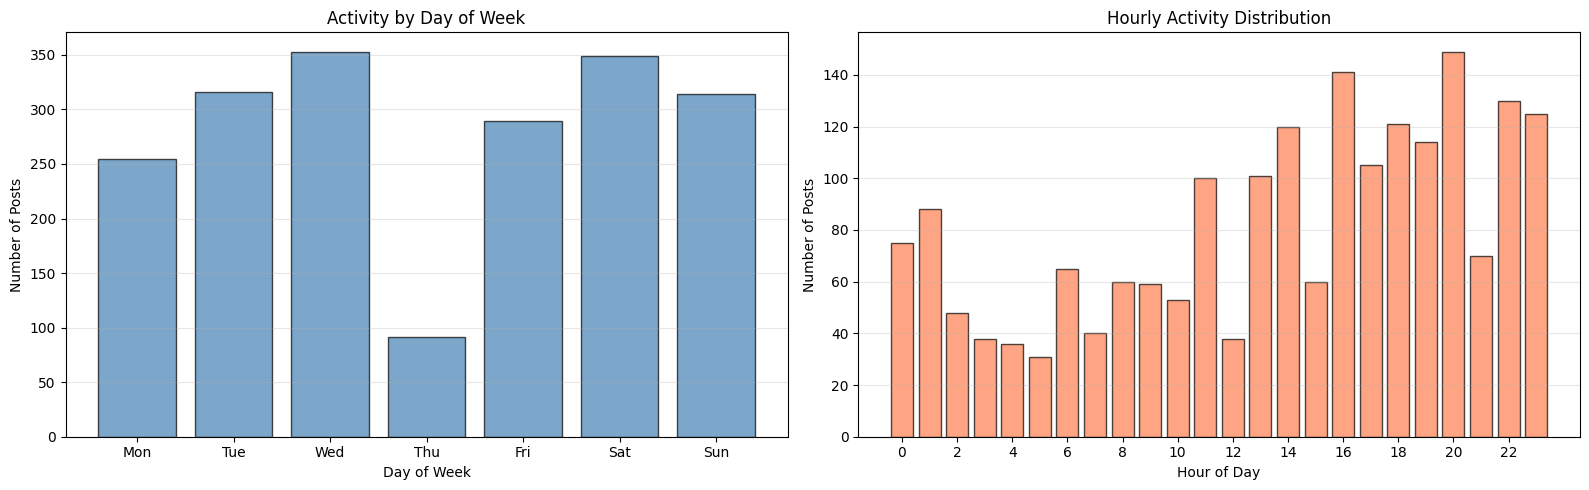

In [13]:
# 5.5 Temporal Analysis

if len(df_unified) > 0 and 'created_utc' in df_unified.columns:

    # Converting to datetime
    valid_dates = df_unified[df_unified['created_utc'].notna()].copy()

    if len(valid_dates) > 0:
        valid_dates['datetime'] = pd.to_datetime(valid_dates['created_utc'], unit='s')

        # Date range
        print(f"\nDate Range:")
        print(f"  Earliest: {valid_dates['datetime'].min()}")
        print(f"  Latest: {valid_dates['datetime'].max()}")
        print(f"  Span: {(valid_dates['datetime'].max() - valid_dates['datetime'].min()).days} days")

        valid_dates['date'] = valid_dates['datetime'].dt.date
        valid_dates['hour'] = valid_dates['datetime'].dt.hour
        valid_dates['day_of_week'] = valid_dates['datetime'].dt.day_name()
        valid_dates['month'] = valid_dates['datetime'].dt.month

        # Posts per day
        daily_counts = valid_dates.groupby('date').size()
        print(f"  Mean posts per day: {daily_counts.mean():.1f}")

        # temporal patterns
        print(f"\nTemporal Distribution Charts:")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        day_counts = valid_dates['day_of_week'].value_counts()
        day_counts_ordered = [int(day_counts.get(d, 0)) for d in day_order]
        ax1.bar(range(7), day_counts_ordered, color='steelblue', alpha=0.7, edgecolor='black')
        ax1.set_xlabel('Day of Week')
        ax1.set_ylabel('Number of Posts')
        ax1.set_title('Activity by Day of Week')
        ax1.set_xticks(range(7))
        ax1.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
        ax1.grid(axis='y', alpha=0.3)

        hour_counts = valid_dates['hour'].value_counts()
        hours = list(range(24))
        counts = [hour_counts.get(h, 0) for h in hours]
        ax2.bar(hours, counts, color='coral', alpha=0.7, edgecolor='black')
        ax2.set_xlabel('Hour of Day')
        ax2.set_ylabel('Number of Posts')
        ax2.set_title('Hourly Activity Distribution')
        ax2.set_xticks(range(0, 24, 2))
        ax2.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.show()

    print()
else:
    print("Warning: No temporal data available for analysis")

**Oukej, peak je úterý/středa a většinou odpolední/večerní hodiny.**

### 5.6 Upvote ratio analysis

Analyzujeme upvote_ratio - poměr kladných hodnocení (upvotes / (upvotes + downvotes)). Tato metrika je dostupná pouze pro posty.

  Mean: 0.821
  Median: 1.000
  Min: 0.080
  Max: 1.000

Upvote Ratio Histogram:


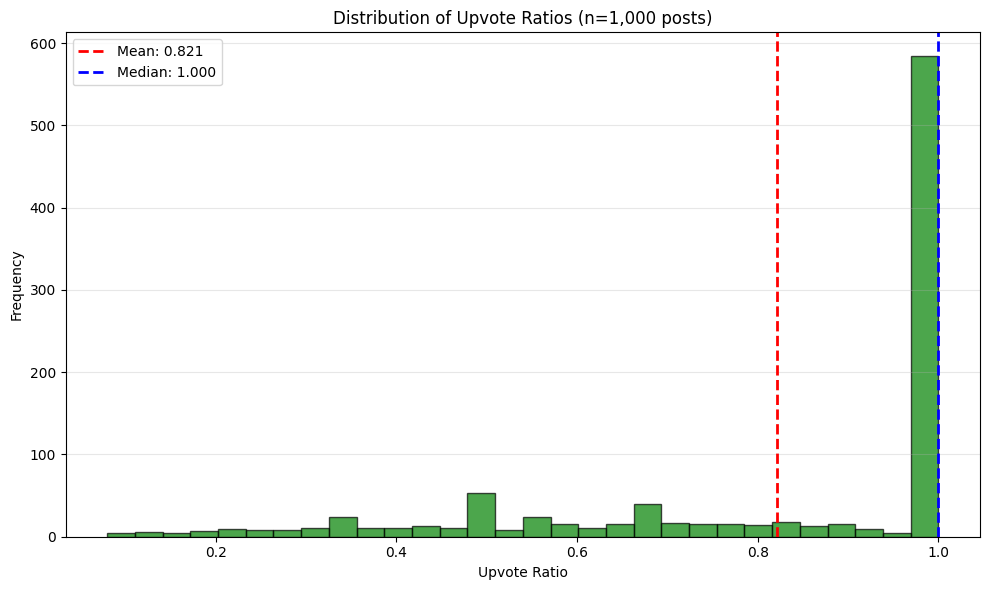

In [14]:
# 5.6 Upvote Ratio Analysis

if len(df_unified) > 0:
    if 'upvote_ratio' in df_unified.columns:
        posts = df_unified[df_unified['type'] == 'post']

        if len(posts) > 0 and 'upvote_ratio' in posts.columns:
            upvote_ratios = posts['upvote_ratio'].dropna()

            if len(upvote_ratios) > 0:
                print(f"  Mean: {upvote_ratios.mean():.3f}")
                print(f"  Median: {upvote_ratios.median():.3f}")
                print(f"  Min: {upvote_ratios.min():.3f}")
                print(f"  Max: {upvote_ratios.max():.3f}")

            print(f"\nUpvote Ratio Histogram:")
            fig, ax = plt.subplots(1, 1, figsize=(10, 6))

            # Histogram
            ax.hist(upvote_ratios, bins=30, edgecolor='black', alpha=0.7, color='green')
            ax.axvline(upvote_ratios.mean(), color='red', linestyle='--', linewidth=2,
                        label=f'Mean: {upvote_ratios.mean():.3f}')
            ax.axvline(upvote_ratios.median(), color='blue', linestyle='--', linewidth=2,
                        label=f'Median: {upvote_ratios.median():.3f}')
            ax.set_xlabel('Upvote Ratio')
            ax.set_ylabel('Frequency')
            ax.set_title(f'Distribution of Upvote Ratios (n={len(upvote_ratios):,} posts)')
            ax.legend()
            ax.grid(axis='y', alpha=0.3)

            plt.tight_layout()
            plt.show()

else:
    print("Warning: No data available for upvote ratio analysis")

Ratio se pohybuje od 0 do 1, většinou velmi pozitivní ratio. 

### 5.7 Integrity and duplicates

Najdeme duplicitní ID a další integrity problémy (chybějící ID, extrémně krátké texty, check na NAs).

In [15]:
# 5.7 Data Integrity & Duplicates

if len(df_unified) > 0:

    # Duplicate IDs
    if 'id' in df_unified.columns:
        total_ids = len(df_unified)
        unique_ids = df_unified['id'].nunique()
        duplicate_ids = total_ids - unique_ids

        print(f"  Total rows: {total_ids:,}")
        print(f"  Unique IDs: {unique_ids:,}")
        print(f"  Duplicate IDs: {duplicate_ids:,} ({duplicate_ids/total_ids*100:.2f}%)")

        if duplicate_ids > 0:
            dup_counts = df_unified['id'].value_counts()
            most_duplicated = dup_counts[dup_counts > 1].head(5)
            print(f"\n  Most duplicated IDs:")
            for id_val, count in most_duplicated.items():
                print(f"    {id_val}: appears {count} times")

    # potential issues
    print(f"\nPotential Data Issues:")
    issues_found = 0

    critical_fields = ['id', 'text', 'created_utc']
    for field in critical_fields:
        if field in df_unified.columns:
            na_count = df_unified[field].isna().sum()
            if na_count > 0:
                print(f"  Warning {field}: {na_count:,} missing values")
                issues_found += 1

    if 'text' in df_unified.columns:
        deleted = df_unified['text'].isin(['[deleted]', '[removed]']).sum()
        if deleted > 0:
            print(f"  Warning: Deleted/removed content: {deleted:,} rows")
            issues_found += 1

    if 'text' in df_unified.columns:
        very_short = (df_unified['text'].astype(str).str.len() <= 5).sum()
        if very_short > 0:
            print(f"  Warning: Extremely short texts (≤5 chars): {very_short:,} rows")
            issues_found += 1

    if issues_found == 0:
        print("No major data quality issues detected")

else:
    print("No data available for integrity analysis")

  Total rows: 1,967
  Unique IDs: 1,967
  Duplicate IDs: 0 (0.00%)

Potential Data Issues:


## 6. Data Cleaning

Odstraníme smazané a prázdné texty, doplníme nebo ošetříme NA a odfiltrujeme příliš krátké záznamy. 

In [16]:
# 6. Data Cleaning: Remove Invalid and Duplicate Content

if len(df_unified) > 0:
    print(f"Starting with {len(df_unified)} rows")

    # Step 6a: Remove invalid texts
    df_cleaned = drop_invalid_texts(df_unified, min_len=MIN_TEXT_LENGTH)
    print(f"    After removing invalid texts: {len(df_cleaned)} rows (-{len(df_unified) - len(df_cleaned)})")

    # Step 6b: Deduplicate and normalize types
    df_cleaned = deduplicate_and_normalize_types(df_cleaned)
    print(f"    After deduplication: {len(df_cleaned)} rows")

    # Step 6c: Dropping unnecessary columns (url, is_original_content, author)
    columns_to_drop = ['url', 'is_original_content', 'author']
    existing_cols_to_drop = [col for col in columns_to_drop if col in df_cleaned.columns]
    if existing_cols_to_drop:
        df_cleaned.drop(columns=existing_cols_to_drop, inplace=True)
        print(f"    Dropped columns: {existing_cols_to_drop}")

    # Show cleaning results
    if len(df_cleaned) > 0:
        print(f"  Original rows: {len(df_unified)}")
        print(f"  Cleaned rows: {len(df_cleaned)}")
        print(f"  Removed: {len(df_unified) - len(df_cleaned)} ({((len(df_unified) - len(df_cleaned))/len(df_unified)*100):.1f}%)")

        # Show data types after cleaning
        print(f"\nData types after cleaning:")
        type_counts = df_cleaned['type'].value_counts()
        for dtype, count in type_counts.items():
            print(f"  {dtype}: {count} rows")
    else:
        print("No data remaining after cleaning.")

else:
    print("No data to clean")
    df_cleaned = pd.DataFrame()

print(f"\nStep 6 complete: {len(df_cleaned)} clean rows")

Starting with 1967 rows
    After removing invalid texts: 1924 rows (-43)
    After deduplication: 1924 rows
    Dropped columns: ['url', 'author']
  Original rows: 1967
  Cleaned rows: 1924
  Removed: 43 (2.2%)

Data types after cleaning:
  post: 999 rows
  comment: 925 rows

Step 6 complete: 1924 clean rows


## 7. Feature engineering

Přidáme potenciálně užitečné sloupce (text_length, word_count, časové atributy, engagement features). Tyhle featury budeme používat při analýze a modelování. Sloupec [score] můžeme po vytvoření [normalized_score] odstranit. [upvote_ratio] odstraňujeme, jelikož je dostupné jen pro posty a neposkytuje tedy dostatečnou informaci.

In [17]:
# 7. Feature Engineering: Add Temporal and Engagement Features

df_features = add_temporal_features(df_cleaned)
df_features = add_engagement_features(df_features)

# Create normalized_score per subreddit (0-1 scale)
if 'score' in df_features.columns and 'subreddit' in df_features.columns:
    df_features['normalized_score'] = df_features.groupby('subreddit')['score'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min() + 1e-6)  # +1e-6 -> to avoid division by zero)
    )

    print(f"\nPer-Subreddit Normalization Check:")
    for sub in df_features['subreddit'].unique():
        sub_data = df_features[df_features['subreddit'] == sub]
        print(f"  {sub}:")
        print(f"    Raw scores: min={sub_data['score'].min():.0f}, "
                f"max={sub_data['score'].max():.0f}, "
                f"mean={sub_data['score'].mean():.1f}")
        print(f"    Normalized: min={sub_data['normalized_score'].min():.3f}, "
                f"max={sub_data['normalized_score'].max():.3f}, "
                f"mean={sub_data['normalized_score'].mean():.3f}")

    # Drop original score column after normalization
    df_features.drop(columns=['score'], inplace=True)

# Drop upvote_ratio (only for posts, creates NAs for comments)
if 'upvote_ratio' in df_features.columns:
    df_features.drop(columns=['upvote_ratio'], inplace=True)

new_features = ['date', 'hour', 'day_of_week', 'month', 'is_weekend',
                'text_length', 'word_count', 'normalized_score']
print(f"\nNew features added: {[f for f in new_features if f in df_features.columns]}")

print(f"\nStep 7 complete: {len(df_features)} rows with enhanced features")



Per-Subreddit Normalization Check:
  ValueInvesting:
    Raw scores: min=-14, max=260, mean=7.2
    Normalized: min=0.000, max=1.000, mean=0.077
  investing:
    Raw scores: min=-64, max=751, mean=5.4
    Normalized: min=0.000, max=1.000, mean=0.085
  stocks:
    Raw scores: min=-87, max=385, mean=8.1
    Normalized: min=0.000, max=1.000, mean=0.201

New features added: ['date', 'hour', 'day_of_week', 'month', 'is_weekend', 'text_length', 'word_count', 'normalized_score']

Step 7 complete: 1924 rows with enhanced features


/var/folders/33/r5z8ht2928103xc7s_sb_xx80000gq/T/ipykernel_17505/3871438954.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_features['normalized_score'] = df_features.groupby('subreddit')['score'].transform(


## 8. Ticker detection

Detekujeme tickery v textu podle načteného seznamu a uložíme je do `mentioned_tickers` a `n_tickers`. Chceme vědět, o které akcie se mluví v jednotlivých záznamech.

### 8.1 Identifying Stock Ticker Mentions

In [18]:
# 8. Ticker Detection: Identify Stock Ticker Mentions

if len(df_features) > 0 and len(tickers_df) > 0:
    print(f"Detecting tickers in {len(df_features)} texts using {len(tickers_df)} symbols")

    df_with_tickers = apply_ticker_detection(df_features, tickers_df)

    # results
    ticker_stats = df_with_tickers['n_tickers'].value_counts().sort_index()
    total_with_tickers = (df_with_tickers['n_tickers'] > 0).sum()
    print(f"  Total rows: {len(df_with_tickers)}")
    print(f"  Rows with tickers: {total_with_tickers} ({total_with_tickers/len(df_with_tickers)*100:.1f}%)")
    print(f"  Rows without tickers: {len(df_with_tickers) - total_with_tickers}")

    print(f"\nTicker count distribution:")
    for count, rows in ticker_stats.head(10).items():
        print(f"  {count} tickers: {rows} rows")

else:
    print("No data or tickers available for detection")
    df_with_tickers = pd.DataFrame()

print(f"\nStep 8 complete: Processed {len(df_with_tickers)} rows for ticker detection")

Detecting tickers in 1924 texts using 8003 symbols


100%|██████████| 1924/1924 [00:00<00:00, 105558.49it/s]

  Total rows: 1924
  Rows with tickers: 354 (18.4%)
  Rows without tickers: 1570

Ticker count distribution:
  0 tickers: 1570 rows
  1 tickers: 248 rows
  2 tickers: 60 rows
  3 tickers: 23 rows
  4 tickers: 9 rows
  5 tickers: 6 rows
  6 tickers: 1 rows
  7 tickers: 3 rows
  11 tickers: 1 rows
  12 tickers: 1 rows

Step 8 complete: Processed 1924 rows for ticker detection


### 8.2 Ticker inheritance — Comments inherit parent post tickers

Pokud komentář nemá zmíněný ticker, vezmeme tickery z rodičovského postu a spojíme je (union). Tím zlepšíme pokrytí tickerů u komentářů, které odkazují na post bez přesný zmínky.

In [19]:
# 8.2 Ticker Inheritance from Parent Posts

if len(df_with_tickers) > 0:
    posts = df_with_tickers[df_with_tickers['type'] == 'post'].copy()
    post_ticker_map = {}

    for _, row in posts.iterrows():
        post_id = row['id']
        tickers_data = row.get('mentioned_tickers', [])

        if isinstance(tickers_data, list) and len(tickers_data) > 0:
            post_ticker_map[post_id] = set(tickers_data)

    def inherit_parent_tickers(row):
        if row['type'] == 'comment':
            parent_id = row.get('parent_post_id')
            if pd.notna(parent_id) and parent_id in post_ticker_map:
                own_tickers = set(row.get('mentioned_tickers', []))
                parent_tickers = post_ticker_map[parent_id]
                merged_tickers = own_tickers.union(parent_tickers)
                return sorted(merged_tickers)

        tickers_data = row.get('mentioned_tickers', [])
        return tickers_data if isinstance(tickers_data, list) else []
    df_with_tickers['mentioned_tickers'] = df_with_tickers.apply(inherit_parent_tickers, axis=1)
    df_with_tickers['n_tickers'] = df_with_tickers['mentioned_tickers'].apply(len)

    # Recalculate ticker_exchanges
    ticker_to_exchange = dict(zip(tickers_df["ticker"], tickers_df["exchange"]))

    def get_ticker_exchanges_from_list(ticker_list):
        """Get exchanges for ticker list after inheritance."""
        if not ticker_list or len(ticker_list) == 0:
            return ''

        exchanges = set()
        for ticker in ticker_list:
            exchange = ticker_to_exchange.get(ticker)
            if exchange:
                exchanges.add(exchange)

        if len(exchanges) == 0:
            return ''
        elif len(exchanges) == 1:
            return list(exchanges)[0]
        else:
            return 'BOTH'

    df_with_tickers['ticker_exchanges'] = df_with_tickers['mentioned_tickers'].apply(
        get_ticker_exchanges_from_list
    )
    print("  Recalculated ticker_exchanges after inheritance")

    comments = df_with_tickers[df_with_tickers['type'] == 'comment']
    comments_with_tickers = comments[comments['n_tickers'] > 0]

    print(f"  Total comments: {len(comments)}")
    print(f"  Comments with tickers (after inheritance): {len(comments_with_tickers)}")
    if len(comments) > 0:
        print(f"  Coverage: {len(comments_with_tickers) / len(comments) * 100:.1f}%")
    else:
        print(f"  Coverage: N/A (no comments)")

    print("\nStep 8.2 completed")
else:
    print("No data to process")

  Recalculated ticker_exchanges after inheritance
  Total comments: 925
  Comments with tickers (after inheritance): 132
  Coverage: 14.3%

Step 8.2 completed


### 8.3 Success check of inheritance

In [20]:
# 8.3 Ticker Inheritance Examples: Show Cases Where Comments GOT Tickers via Inheritance

if len(df_with_tickers) > 0:
    comments = df_with_tickers[df_with_tickers['type'] == 'comment'].copy()
    comments_with_tickers = comments[comments['n_tickers'] > 0]
    comments_with_parents = comments_with_tickers[comments_with_tickers['parent_post_id'].notna()]

    def has_ticker_in_text(text, tickers_str):
        if not text or not tickers_str:
            return False
        text_upper = str(text).upper()
        ticker_list = str(tickers_str).split(',')

        for ticker in ticker_list:
            ticker = ticker.strip()
            words = text_upper.split()
            if ticker in words:
                return True
            if f"${ticker}" in text_upper:
                return True
        return False

    inherited_only = []
    explicit_mention = []

    for idx, comment in comments_with_parents.iterrows():
        has_explicit = has_ticker_in_text(comment['text'], comment['mentioned_tickers'])

        if has_explicit:
            explicit_mention.append(comment)
        else:
            inherited_only.append(comment)
    print(f"Total comments with tickers: {len(comments_with_tickers)}")
    print(f"Comments that inherited tickers: {len(inherited_only)}")
    print(f"Comments that mention tickers explicitly: {len(explicit_mention)}")
    print(f"Inheritance success rate: {len(inherited_only)/len(comments_with_tickers)*100:.1f}%")

    # Drop parent_post_id after inheritance is complete
    if 'parent_post_id' in df_with_tickers.columns:
        df_with_tickers.drop(columns=['parent_post_id'], inplace=True)
        print(f"\nDropped 'parent_post_id' column (no longer needed after ticker inheritance)")
else:
    print("No data available for analysis.")

Total comments with tickers: 132
Comments that inherited tickers: 132
Comments that mention tickers explicitly: 0
Inheritance success rate: 100.0%

Dropped 'parent_post_id' column (no longer needed after ticker inheritance)

Comments that inherited tickers: 132
Comments that mention tickers explicitly: 0
Inheritance success rate: 100.0%

Dropped 'parent_post_id' column (no longer needed after ticker inheritance)


### 8.4 Data Type Conversion

Ensure all columns have the correct data types after feature engineering and ticker detection. This is done here (after Step 8.2) to ensure type conversions persist through the pipeline.

In [21]:
# 8.4 Comprehensive Data Type Conversion

if len(df_with_tickers) > 0:
    # Datetime conversions
    df_with_tickers['created_utc'] = pd.to_datetime(df_with_tickers['created_utc'])
    df_with_tickers['date'] = pd.to_datetime(df_with_tickers['date'])

    # Integer conversions
    df_with_tickers['hour'] = df_with_tickers['hour'].astype('int8')
    df_with_tickers['month'] = df_with_tickers['month'].astype('int8')
    df_with_tickers['text_length'] = df_with_tickers['text_length'].astype('int32')
    df_with_tickers['word_count'] = df_with_tickers['word_count'].astype('int32')
    df_with_tickers['n_tickers'] = df_with_tickers['n_tickers'].astype('int16')

    # Boolean conversions
    df_with_tickers['is_weekend'] = df_with_tickers['is_weekend'].astype('bool')

    # Category conversions
    df_with_tickers['day_of_week'] = df_with_tickers['day_of_week'].astype('category')
    df_with_tickers['type'] = df_with_tickers['type'].astype('category')
    df_with_tickers['subreddit'] = df_with_tickers['subreddit'].astype('category')

    # Float conversions
    if 'normalized_score' in df_with_tickers.columns:
        df_with_tickers['normalized_score'] = df_with_tickers['normalized_score'].astype('float32')

    print(f"\nData types after conversion:")
    print(f"  created_utc: {df_with_tickers['created_utc'].dtype}")
    print(f"  date: {df_with_tickers['date'].dtype}")
    print(f"  type: {df_with_tickers['type'].dtype}")
    print(f"  subreddit: {df_with_tickers['subreddit'].dtype}")
    print(f"  hour: {df_with_tickers['hour'].dtype}")
    print(f"  day_of_week: {df_with_tickers['day_of_week'].dtype}")
    print(f"  is_weekend: {df_with_tickers['is_weekend'].dtype}")
    print(f"  text_length: {df_with_tickers['text_length'].dtype}")
    print(f"  word_count: {df_with_tickers['word_count'].dtype}")
    print(f"  n_tickers: {df_with_tickers['n_tickers'].dtype}")
    if 'normalized_score' in df_with_tickers.columns:
        print(f"  normalized_score: {df_with_tickers['normalized_score'].dtype}")
else:
    print("No data available")



Data types after conversion:
  created_utc: datetime64[ns]
  date: datetime64[ns]
  type: category
  subreddit: category
  hour: int8
  day_of_week: category
  is_weekend: bool
  text_length: int32
  word_count: int32
  n_tickers: int16
  normalized_score: float32


## 9. Text normalization

Připravíme text pro sentiment a modely (tokenizace, lemmatizace, odstranění stopwords). 

In [22]:
# 9. Text Normalization: Prepare Text for Sentiment Analysis
# Tickers are already stored in 'mentioned_tickers' column, so we don't need to preserve them in text

if len(df_with_tickers) > 0:
    df_final = apply_text_normalization(df_with_tickers, keep_tickers=False)
    if SPACY_AVAILABLE:
        df_final['sentiment_ready_text'] = df_final['sentiment_ready_text'].apply(
            lambda x: remove_stopwords_spacy(x, preserve_tickers=False)
        )
        stopword_method = "spaCy"
    elif NLTK_AVAILABLE:
        print("Using NLTK")
        df_final['sentiment_ready_text'] = df_final['sentiment_ready_text'].apply(
            lambda x: remove_financial_stopwords(x, preserve_tickers=False)
        )
        stopword_method = "NLTK"
    else:
        print("Using built-in stopword removal (basic)")
        df_final['sentiment_ready_text'] = df_final['sentiment_ready_text'].apply(
            lambda x: remove_financial_stopwords(x, preserve_tickers=False)
        )
        stopword_method = "Built-in"

    print(f"Text normalization complete using {stopword_method}")
    print(f"Final dataframe shape: {df_final.shape}")
    print(f"Final columns: {list(df_final.columns)}")

    # Final statistics
    print(f"\nFinal dataset statistics:")
    print(f"  Total rows: {len(df_final)}")
    print(f"  Rows with tickers: {(df_final['n_tickers'] > 0).sum()}")
    print(f"  Average original text length: {df_final['text_length'].mean():.1f} characters")
    print(f"  Average word count: {df_final['word_count'].mean():.1f} words")

    # Show text processing impact
    avg_original_length = df_final['text'].str.len().mean()
    avg_sentiment_ready_length = df_final['sentiment_ready_text'].str.len().mean()

    print(f"\nimpact:")
    print(f"  Original text length: {avg_original_length:.1f} chars")
    print(f"  Sentiment-ready text length: {avg_sentiment_ready_length:.1f} chars")
    print(f"  Reduction from normalization: {((avg_original_length - avg_sentiment_ready_length) / avg_original_length * 100):.1f}%")
    print(f"  Stopword removal method: {stopword_method}")

    if 'type' in df_final.columns:
        type_dist = df_final['type'].value_counts()

else:
    print("No data for text normalization")
    df_final = pd.DataFrame()

print(f"\nStep 9 complete: {len(df_final)} rows ready for sentiment analysis.")

100%|██████████| 1924/1924 [00:00<00:00, 61916.62it/s]



Text normalization complete using spaCy
Final dataframe shape: (1924, 17)
Final columns: ['created_utc', 'id', 'text', 'subreddit', 'type', 'date', 'hour', 'day_of_week', 'month', 'is_weekend', 'text_length', 'word_count', 'normalized_score', 'mentioned_tickers', 'n_tickers', 'ticker_exchanges', 'sentiment_ready_text']

Final dataset statistics:
  Total rows: 1924
  Rows with tickers: 354
  Average original text length: 359.8 characters
  Average word count: 60.6 words

impact:
  Original text length: 359.8 chars
  Sentiment-ready text length: 211.1 chars
  Reduction from normalization: 41.3%
  Stopword removal method: spaCy

Step 9 complete: 1924 rows ready for sentiment analysis.


- **zkontrolujeme finální dataframe, můžeme dropnout [text] a nechat jen řádky s alespoň jedním tickerem**

In [23]:
df_final.drop(columns = ['text'], inplace=True)
df_final = df_final[df_final['n_tickers'] > 0].reset_index(drop=True)
display(df_final.head(10))

,created_utc,id,subreddit,type,date,hour,day_of_week,month,is_weekend,text_length,word_count,normalized_score,mentioned_tickers,n_tickers,ticker_exchanges,sentiment_ready_text
0,2024-08-27 14:56:56,1f2j5mx,ValueInvesting,post,2024-08-27,14,Tuesday,8,False,647,105,0.094891,[SMCI],1,NASDAQ,smci super micro receives fair bit discussion ...
1,2024-08-27 15:46:11,1f2kctk,ValueInvesting,post,2024-08-27,15,Tuesday,8,False,6964,1094,0.058394,"[NPV, SCI]",2,NYSE,death taxes service corporation international ...
2,2024-08-18 00:39:29,1euwlfr,ValueInvesting,post,2024-08-18,0,Sunday,8,True,252,50,0.062044,[AI],1,NYSE,ai generate equity research reports m trying u...
3,2024-08-18 02:05:27,1euy95i,ValueInvesting,post,2024-08-18,2,Sunday,8,True,524,92,0.069343,"[DHI, LEN, PHM]",3,NYSE,looking homebuilders feel like presents good o...
4,2024-08-18 05:24:02,1ev1p37,ValueInvesting,post,2024-08-18,5,Sunday,8,True,264,51,0.142336,[ZM],1,NASDAQ,zm deep value play past peak zoom trading near...
5,2024-08-23 06:34:42,1ez5wkw,ValueInvesting,post,2024-08-23,6,Friday,8,False,5088,929,0.255474,"[AI, BBB, UK]",3,BOTH,mcdonald s hideously overpriced underestimatin...
6,2024-08-23 10:17:55,1ez95tu,ValueInvesting,post,2024-08-23,10,Friday,8,False,347,62,0.091241,[SIRI],1,NASDAQ,liberty sirius xm sirius xm merger arbitrage d...
7,2024-08-23 10:35:25,1ez9fpd,ValueInvesting,post,2024-08-23,10,Friday,8,False,8178,1338,0.076642,"[FCF, OR, PR, SIG, SWBI]",5,BOTH,analysis smith wesson brands inc stg idiots lo...
8,2024-08-23 11:00:11,1ez9u2q,ValueInvesting,post,2024-08-23,11,Friday,8,False,32,5,0.054745,[ZIM],1,NYSE,invested zim suggestion
9,2024-08-27 18:10:50,1f2nxdh,ValueInvesting,post,2024-08-27,18,Tuesday,8,False,2129,337,0.065693,"[CF, ENS, ROE]",3,BOTH,enersys ens imo enersys positioned good growth...


## 10. Exporting results

Uložíme finální dataset s připraveným textem a featurami (CSV). 

In [25]:
# 10. Export Results: Save Sentiment-Ready Data

if len(df_final) > 0:
    print(f"Available columns: {list(df_final.columns)}")

    output_file = "preprocessed_data.csv"

    # Select columns for export
    export_columns = [
        'id', 'sentiment_ready_text', 'type', 'subreddit',
        'created_utc', 'normalized_score', 'mentioned_tickers',
        'n_tickers', 'ticker_exchanges', 'text_length', 'word_count',
        'date', 'hour', 'day_of_week'
    ]

    export_cols = [col for col in export_columns if col in df_final.columns]
    export_df = df_final[export_cols].copy()

    # Convert mentioned_tickers from list to comma-separated string
    if 'mentioned_tickers' in export_df.columns:
        export_df['mentioned_tickers'] = export_df['mentioned_tickers'].apply(
            lambda x: ','.join(x) if isinstance(x, list) and len(x) > 0 else ''
        )
        print(f"Converted 'mentioned_tickers' from list to comma-separated string format")

    # Convert day_of_week from category to numeric for database compatibility
    if 'day_of_week' in export_df.columns:
        day_mapping = {
            'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
            'Friday': 4, 'Saturday': 5, 'Sunday': 6
        }
        export_df['day_of_week'] = export_df['day_of_week'].map(day_mapping)
        print(f"Converted 'day_of_week' from category to numeric (0-6)")

    # Export to CSV
    export_df.to_csv(output_file, index=False)
    print(f"\nExported {len(export_df)} rows to {output_file}")
    print(f"Exported columns: {export_cols}")

    if 'ticker_exchanges' in export_df.columns:
        exchange_dist = export_df[export_df['ticker_exchanges'] != '']['ticker_exchanges'].value_counts()
        print(f"\nExchange distribution (rows with tickers):")
        for exchange, count in exchange_dist.items():
            print(f"  {exchange}: {count} rows")

    if 'normalized_score' in export_df.columns:
        print(f"\nNormalized Score Statistics:")
        print(f"  Mean: {export_df['normalized_score'].mean():.3f}")
        print(f"  Median: {export_df['normalized_score'].median():.3f}")
        print(f"  Range: [{export_df['normalized_score'].min():.3f}, {export_df['normalized_score'].max():.3f}]")

else:
    print("No data to export")
    export_df = pd.DataFrame()

print(f"\nStep 10 complete: CSV export finished.")


Available columns: ['created_utc', 'id', 'subreddit', 'type', 'date', 'hour', 'day_of_week', 'month', 'is_weekend', 'text_length', 'word_count', 'normalized_score', 'mentioned_tickers', 'n_tickers', 'ticker_exchanges', 'sentiment_ready_text']
Converted 'mentioned_tickers' from list to comma-separated string format
Converted 'day_of_week' from category to numeric (0-6)

Exported 354 rows to preprocessed_data.csv
Exported columns: ['id', 'sentiment_ready_text', 'type', 'subreddit', 'created_utc', 'normalized_score', 'mentioned_tickers', 'n_tickers', 'ticker_exchanges', 'text_length', 'word_count', 'date', 'hour', 'day_of_week']

Exchange distribution (rows with tickers):
  NYSE: 146 rows
  NASDAQ: 145 rows
  BOTH: 63 rows

Normalized Score Statistics:
  Mean: 0.094
  Median: 0.080
  Range: [0.000, 0.774]

Step 10 complete: CSV export finished.


## 11. Database Export — Oracle

Exportujeme preprocessovaná data do Oracle tabulky `preprocessed_data` pro další použití v analýze sentimentu.

In [26]:
# 11. Database Export: Save to Oracle
conn = get_oracle_connection()

if conn:
    cursor = conn.cursor()

    # Truncate existing data
    cursor.execute("TRUNCATE TABLE preprocessed_data")
    print("Existing data truncated")

    # Insert statement
    insert_sql = """
    INSERT INTO preprocessed_data (
        id, sentiment_ready_text, type, subreddit,
        created_utc, normalized_score, mentioned_tickers,
        n_tickers, ticker_exchanges, text_length, word_count,
        date_col, hour, day_of_week
    ) VALUES (
        :1, :2, :3, :4, :5, :6, :7, :8, :9, :10, :11, :12, :13, :14
    )
    """

    # Prepare data for batch insert (using already converted export_df from Step 10)
    insert_data = []
    for _, row in export_df.iterrows():
        insert_data.append((
            str(row['id']),
            str(row['sentiment_ready_text']),
            str(row['type']),
            str(row['subreddit']),
            row['created_utc'].timestamp() if pd.notna(row['created_utc']) else None,
            float(row['normalized_score']) if pd.notna(row['normalized_score']) else None,
            str(row['mentioned_tickers']) if pd.notna(row['mentioned_tickers']) else '',
            int(row['n_tickers']) if pd.notna(row['n_tickers']) else 0,
            str(row['ticker_exchanges']) if pd.notna(row['ticker_exchanges']) else '',
            int(row['text_length']) if pd.notna(row['text_length']) else 0,
            int(row['word_count']) if pd.notna(row['word_count']) else 0,
            row['date'] if pd.notna(row['date']) else None,
            int(row['hour']) if pd.notna(row['hour']) else None,
            int(row['day_of_week']) if pd.notna(row['day_of_week']) else None
        ))

    # Execute batch insert
    cursor.executemany(insert_sql, insert_data)
    conn.commit()

    print(f"Successfully exported {len(insert_data)} rows to Oracle table 'preprocessed_data'")

    cursor.close()
    conn.close()
    print("Database export complete!")

else:
    print("Failed to connect to Oracle database")
    try:
        if conn:
            conn.close()
    except:
        pass


print(f"\nStep 11 complete: Database export finished")

Oracle connection successful!
Existing data truncated
Successfully exported 354 rows to Oracle table 'preprocessed_data'
Database export complete!

Step 11 complete: Database export finished
Successfully exported 354 rows to Oracle table 'preprocessed_data'
Database export complete!

Step 11 complete: Database export finished
